In [10]:
# Import Libraries
import pandas as pd
import yfinance as yf
import finta
import plotly.graph_objects as go
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import plotly.io as pio
import kaleido

In [11]:
def plot_SMA(stock_symbol):
    # Download historical data for the specified stock symbol
    #df = yf.download(stock_symbol, start="2021-07-01", end="2023-06-01", interval="1h")
    df = yf.download(stock_symbol, start="2023-05-10", end="2023-06-01", interval="5m")

    df["actual_returns"] = df['Close'].pct_change()

    # Compute SMAs
    df['SMA_9'] = df['Close'].rolling(window=9).mean()
    df['SMA_21'] = df['Close'].rolling(window=21).mean()

    # Compute EMA
    df['EMA_200'] = df['Close'].ewm(span=200, adjust=False).mean()

    # Create a Candlestick chart
    trace_candle = go.Candlestick(x=df.index, open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'], name='Candlestick')

    # Dropping unnecessary columns
    df = df.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
    df.dropna(inplace=True)

    # Create traces for SMAs, EMA
    trace_sma_9 = go.Scatter(x=df.index, y=df['SMA_9'], line={'color': 'green'}, name='SMA 9')
    trace_sma_21 = go.Scatter(x=df.index, y=df['SMA_21'], line={'color': 'black'}, name='SMA 21')
    trace_ema_200 = go.Scatter(x=df.index, y=df['EMA_200'], line={'color': 'yellow'}, name='EMA 200')

    # Create layout
    layout = go.Layout(title=f'{stock_symbol} with SMAs and EMA 200',
                       xaxis=dict(title="Date"),
                       yaxis=dict(title="Price"),
                       width=1200,
                       height=800)

    # Create figure and add traces
    fig1 = go.Figure(data=[trace_candle, trace_sma_9, trace_sma_21, trace_ema_200], layout=layout)
    
    # Save as image
    pio.write_image(fig1, f'{stock_symbol}_with_SMAs_EMA200_5m.png')


    # Show the figure
    fig1.show()

    # Initialize the new Signal column
    df['signal'] = 0

    # Comparing elements element-wise and assigning signals
    df.loc[(df['SMA_9'] < df['EMA_200']) & (df['SMA_21'] < df['EMA_200']), 'signal'] = -1  # Sell signal
    df.loc[(df['SMA_9'] > df['EMA_200']) & (df['SMA_21'] > df['EMA_200']), 'signal'] = 1  # Buy signal

    print (df)

    # Copy the new signal column to a new Series called y.
    y = df["signal"].copy()

    # Assign a copy of the sma_fast and sma_slow columns to a new DataFrame called X
    X = df[["SMA_9", "SMA_21", "EMA_200"]].copy()
    
    # Select the start of the training period
    training_begin = X.index.min()

    # Select the ending period for the training data with an offset of 3 months
    training_end = X.index.min() + DateOffset(days=18)

    # Display the training end date
    print(training_end)

    # Generate the X_train and y_train DataFrames
    X_train = X.loc[training_begin:training_end]
    y_train = y.loc[training_begin:training_end]

    
    # Generate the X_test and y_test DataFrames
    X_test = X.loc[training_end:]
    y_test = y.loc[training_end:]

    # Create a StandardScaler instance
    scaler = StandardScaler()

    # Apply the scaler model to fit the X-train data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create the SVC model
    model = SVC()

    # Fit the model to the training data
    model.fit(X_train_scaled, y_train)

    # Use the trained model to predict the trading signals for the training data
    training_signal_predictions = model.predict(X_train_scaled)

    # Evaluate the model using a classification report
    training_report = classification_report(y_train, training_signal_predictions)
    print (f"\n{stock_symbol}_Classification_report_5m: Training")
    print(training_report)

    # Use the trained model to predict the trading signals for the testing data
    testing_signal_predictions = model.predict(X_test_scaled)

    # Evaluate the model's ability to predict the trading signal for the testing data
    testing_report = classification_report(y_test, testing_signal_predictions)
    print (f"\n{stock_symbol}_Classification_report_5m: Testing")
    print(testing_report)

    # Create a new empty predictions DataFrame
    predictions_df = pd.DataFrame(index=X_test.index)
    predictions_df["predicted_signal"] = testing_signal_predictions
    predictions_df["actual_returns"] = df["actual_returns"]
    predictions_df["trading_algorithm_returns"] = predictions_df["actual_returns"] * predictions_df["predicted_signal"]
    print ("\nPredictions")
    print(predictions_df.head())

    # Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
    (1 + predictions_df[['actual_returns', 'trading_algorithm_returns']]).cumprod().plot(kind='line')
    
    # Save the plot as an image
    plt.savefig(f'{stock_symbol}_cumulative_returns_plot_5m.png')
    
    plt.show()
    

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


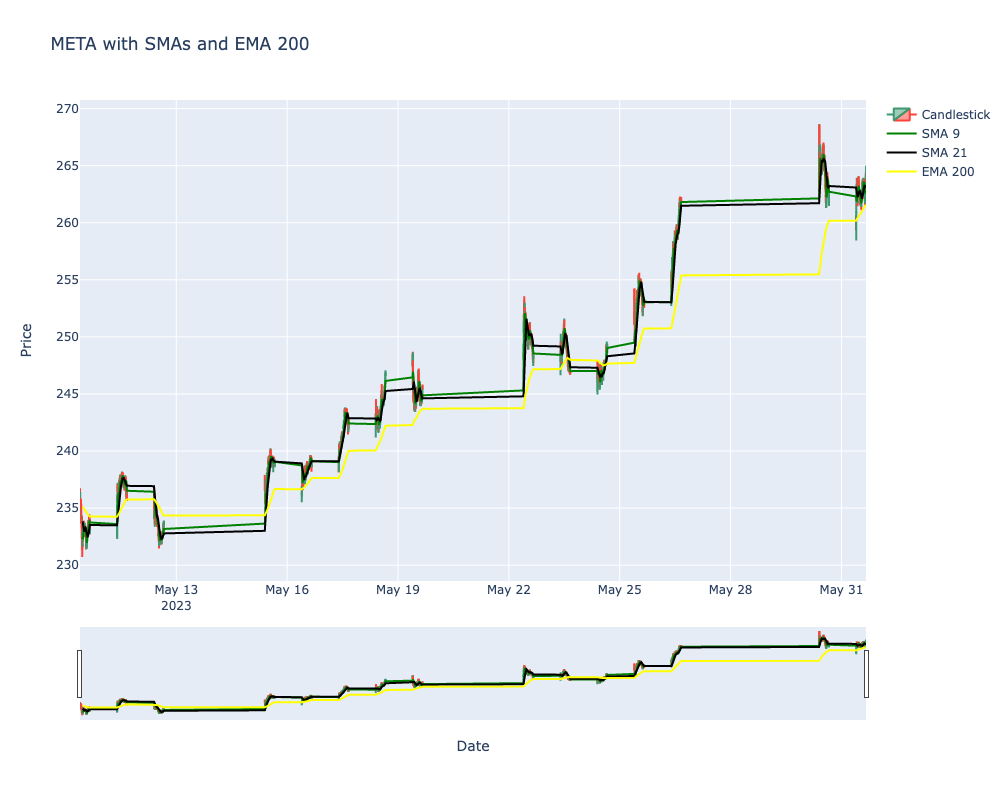

                           actual_returns       SMA_9      SMA_21     EMA_200  \
Datetime                                                                        
2023-05-10 11:10:00-04:00       -0.000901  232.473531  233.831466  235.127839   
2023-05-10 11:15:00-04:00        0.002455  232.302421  233.701047  235.103781   
2023-05-10 11:20:00-04:00        0.001719  232.273532  233.575333  235.083943   
2023-05-10 11:25:00-04:00        0.001667  232.383377  233.496695  235.068168   
2023-05-10 11:30:00-04:00        0.000563  232.503245  233.433957  235.053858   
...                                   ...         ...         ...         ...   
2023-05-31 15:35:00-04:00        0.001425  262.605852  263.118368  261.495403   
2023-05-31 15:40:00-04:00       -0.000550  262.633328  263.109801  261.513757   
2023-05-31 15:45:00-04:00        0.002734  262.810550  263.149320  261.539093   
2023-05-31 15:50:00-04:00       -0.000341  263.011661  263.160273  261.563281   
2023-05-31 15:55:00-04:00   

/Users/athuthava/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/athuthava/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/athuthava/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



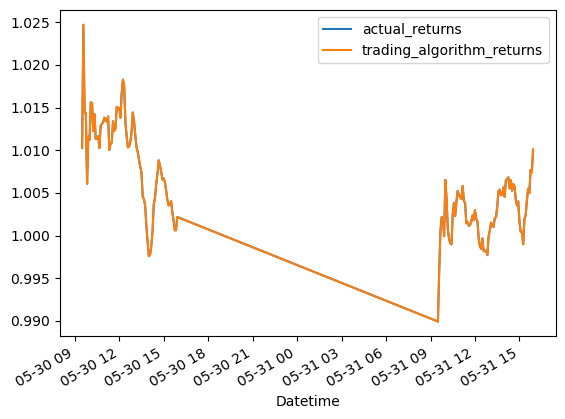

[*********************100%***********************]  1 of 1 completed


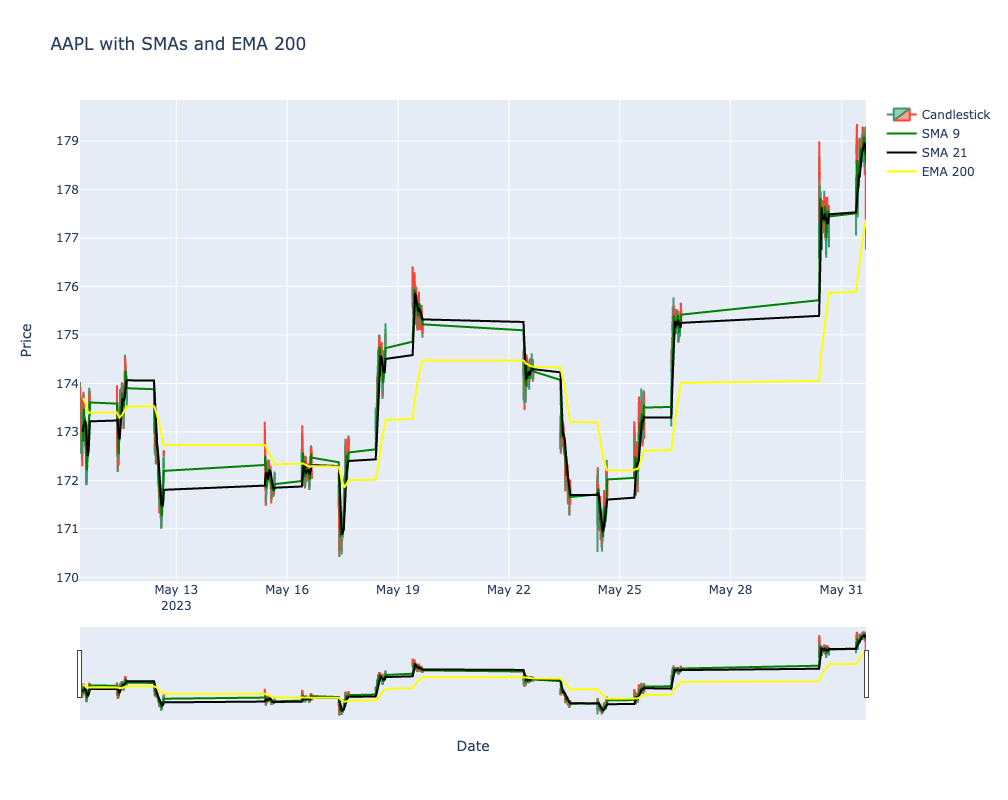

                           actual_returns       SMA_9      SMA_21     EMA_200  \
Datetime                                                                        
2023-05-10 11:10:00-04:00       -0.001082  172.850869  173.057778  173.695053   
2023-05-10 11:15:00-04:00        0.000519  172.799203  173.013173  173.687241   
2023-05-10 11:20:00-04:00        0.002082  172.805869  173.006507  173.683090   
2023-05-10 11:25:00-04:00        0.000116  172.874769  173.019840  173.679179   
2023-05-10 11:30:00-04:00        0.002307  172.980313  173.057226  173.679286   
...                                   ...         ...         ...         ...   
2023-05-31 15:35:00-04:00        0.000084  178.651420  178.870775  177.343816   
2023-05-31 15:40:00-04:00        0.001734  178.695875  178.875066  177.361789   
2023-05-31 15:45:00-04:00        0.000390  178.762543  178.890305  177.380279   
2023-05-31 15:50:00-04:00       -0.009374  178.649209  178.812685  177.381868   
2023-05-31 15:55:00-04:00   

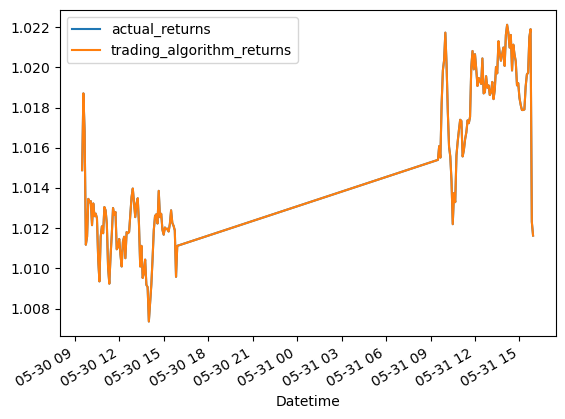

[*********************100%***********************]  1 of 1 completed


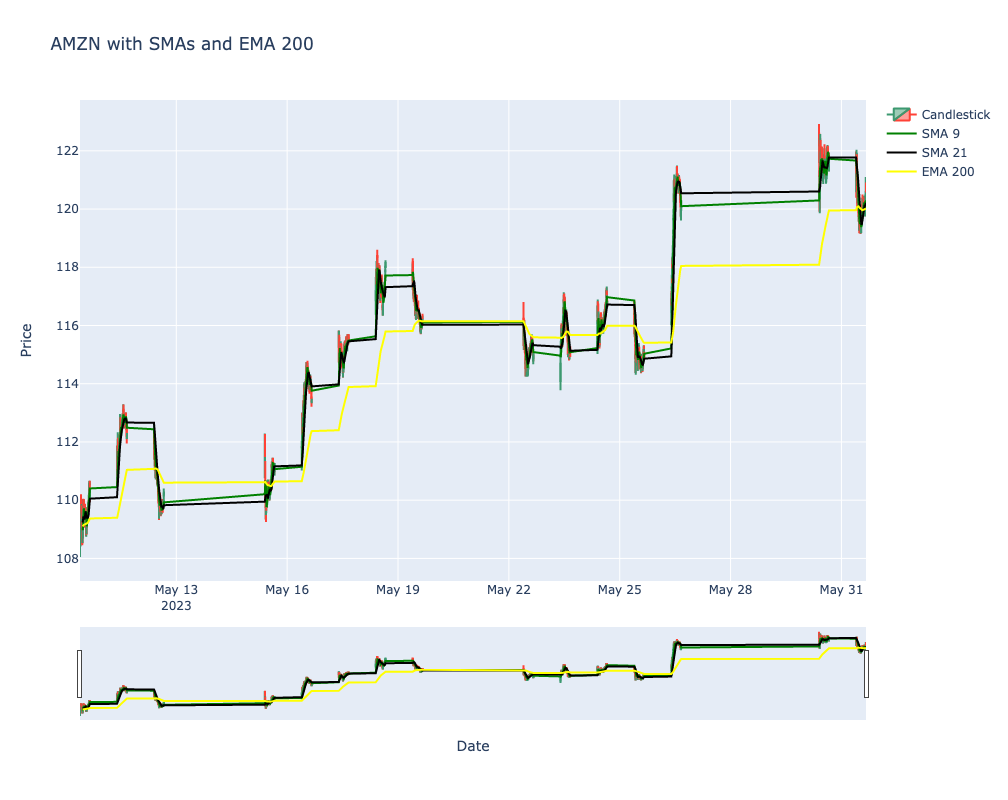

                           actual_returns       SMA_9      SMA_21     EMA_200  \
Datetime                                                                        
2023-05-10 11:10:00-04:00       -0.001378  109.056278  109.234848  109.100099   
2023-05-10 11:15:00-04:00        0.002667  108.982944  109.232467  109.099302   
2023-05-10 11:20:00-04:00        0.005137  108.968289  109.260562  109.104085   
2023-05-10 11:25:00-04:00        0.001186  109.033333  109.297086  109.110114   
2023-05-10 11:30:00-04:00        0.001732  109.106667  109.357086  109.117973   
...                                   ...         ...         ...         ...   
2023-05-31 15:35:00-04:00        0.000666  120.044766  120.125047  119.993157   
2023-05-31 15:40:00-04:00        0.001497  120.063099  120.145285  119.997504   
2023-05-31 15:45:00-04:00        0.000872  120.120322  120.164809  120.002852   
2023-05-31 15:50:00-04:00        0.002874  120.222700  120.197733  120.011594   
2023-05-31 15:55:00-04:00   

/Users/athuthava/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/athuthava/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/athuthava/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/athuthava/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and

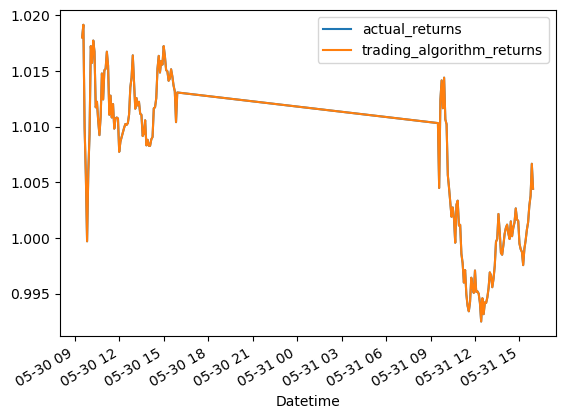

[*********************100%***********************]  1 of 1 completed


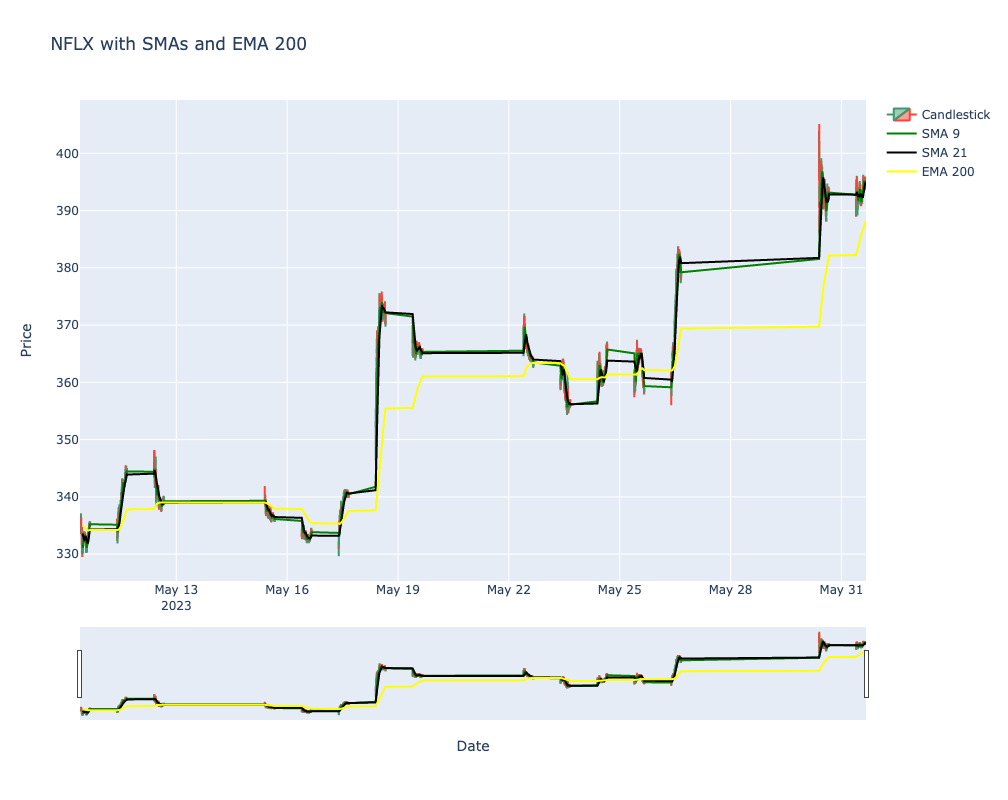

                           actual_returns       SMA_9      SMA_21     EMA_200  \
Datetime                                                                        
2023-05-10 11:10:00-04:00       -0.002747  331.664927  333.603292  334.959086   
2023-05-10 11:15:00-04:00        0.003209  331.319441  333.417103  334.923573   
2023-05-10 11:20:00-04:00        0.000593  331.116272  333.248840  334.890368   
2023-05-10 11:25:00-04:00        0.003991  331.238495  333.147412  334.870663   
2023-05-10 11:30:00-04:00        0.001562  331.429606  333.100669  334.856328   
...                                   ...         ...         ...         ...   
2023-05-31 15:35:00-04:00       -0.000152  394.538096  394.815608  388.019071   
2023-05-31 15:40:00-04:00       -0.000836  394.472541  394.822751  388.083260   
2023-05-31 15:45:00-04:00        0.002814  394.654761  394.877513  388.157854   
2023-05-31 15:50:00-04:00       -0.001441  394.749207  394.871504  388.226035   
2023-05-31 15:55:00-04:00   

/Users/athuthava/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/athuthava/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/athuthava/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



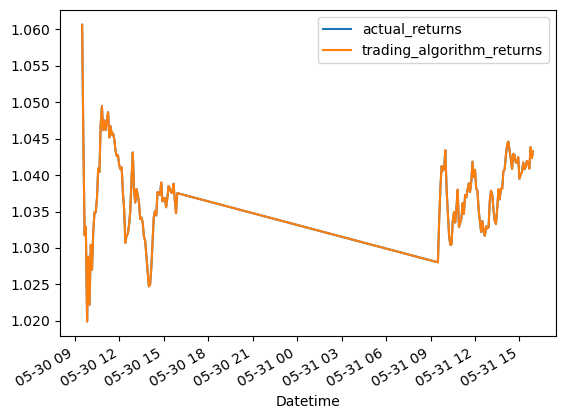

[*********************100%***********************]  1 of 1 completed


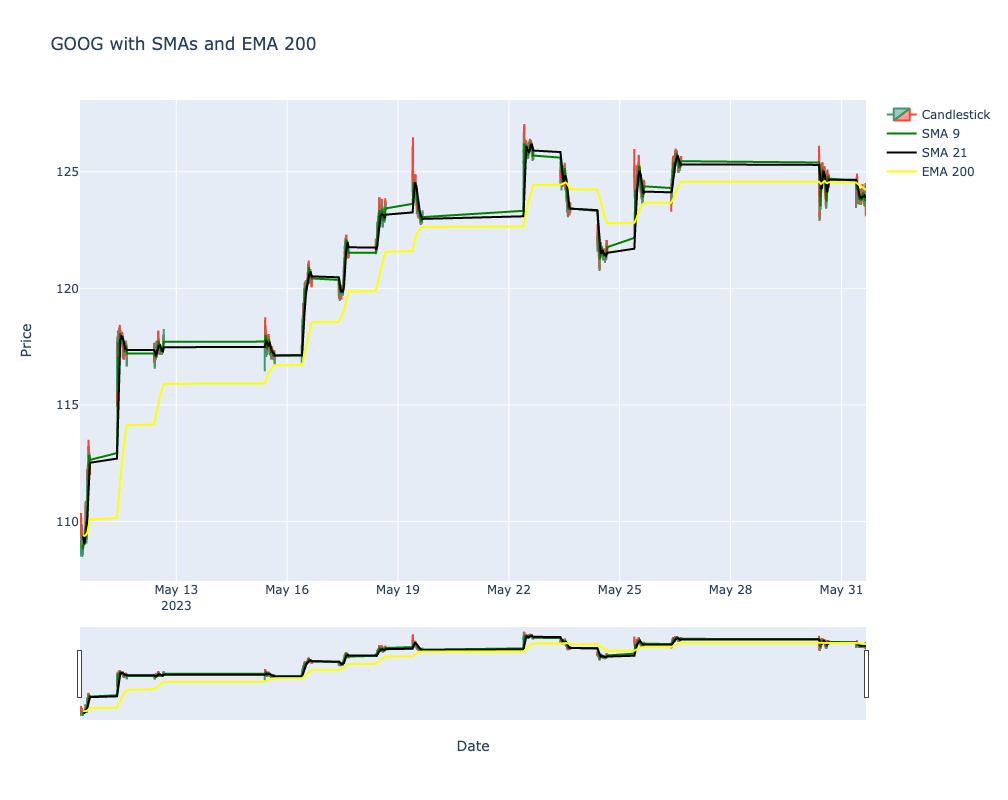

                           actual_returns       SMA_9      SMA_21     EMA_200  \
Datetime                                                                        
2023-05-10 11:10:00-04:00       -0.001838  108.989545  109.432519  109.416378   
2023-05-10 11:15:00-04:00        0.001335  108.870656  109.400472  109.409698   
2023-05-10 11:20:00-04:00        0.002621  108.805100  109.366662  109.405920   
2023-05-10 11:25:00-04:00       -0.000459  108.816656  109.329281  109.401682   
2023-05-10 11:30:00-04:00        0.001927  108.842223  109.302139  109.399576   
...                                   ...         ...         ...         ...   
2023-05-31 15:35:00-04:00        0.000806  123.864443  123.912080  124.239872   
2023-05-31 15:40:00-04:00        0.000805  123.914999  123.920237  124.240370   
2023-05-31 15:45:00-04:00        0.001529  124.009444  123.940237  124.242755   
2023-05-31 15:50:00-04:00       -0.008274  123.993889  123.910714  124.234867   
2023-05-31 15:55:00-04:00   

/Users/athuthava/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/athuthava/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/athuthava/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/athuthava/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and

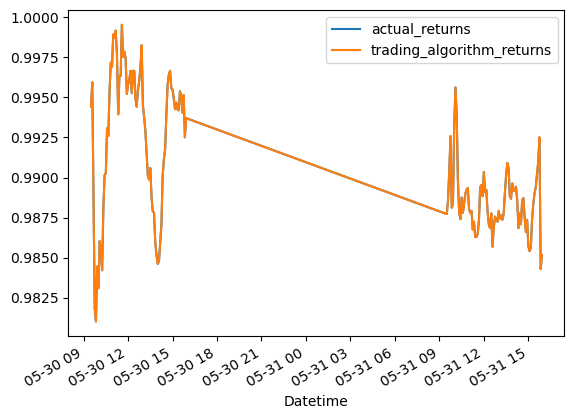

In [12]:
# Import Data from Yahoo Finance
stocks = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOG']
dfs = {}

#start_date = "2021-07-01"
start_date = "2023-05-10"
end_date = "2023-06-01"

for stock in stocks:
    #dfs[stock] = yf.download(stock, start=start_date, end=end_date, interval="1h")
    dfs[stock] = yf.download(stock, start=start_date, end=end_date, interval="5m")

# Plotting Bollinger Bands and SMAs for each stock
for stock, df in dfs.items():
    plot_SMA(stock)